# Flappy Bird - Dueling Deep Q-Network

In this notebook, we will implement a **Dueling Deep Q-Network (DQN)** for the Flappy Bird game.

The **Deep Q-Network (DQN) algorithm** is a variant of the Q-Learning that uses a neural network to approximate the Q-function. In 2013, DeepMind proposed this algorithm as a way to solve Atari games with a high level of efficiency.

By explicitly separating two estimators, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state.

Two different memory approaches are used:

- **Experience Replay (ER)**: The most common approach, where the most recent experiences are stored in a replay memory.
- **Prioritized Experience Replay (PER)**: The approach where experiences are stored in a replay memory and the importance of each experience is stored in a priority queue.

## Index

- [1. Initial Setup](#1.-Initial-Setup)
- [2. Check the Gym environment](#2-check-the-gym-environment)
- [3. Define custom functions](#3-define-custom-functions)
- [4. Training the RL agent](#4-training-the-rl-agent)
  - [4.1 Agent (Replay Memory) - Training](#4-1-agent-replay-memory-training)
  - [4.1 Agent (Replay Memory) - Scores](#4-1-agent-replay-memory-scores)
  - [4.1 Agent (Replay Memory) - Losses](#4-1-agent-replay-memory-losses)
  - [4.2 Agent (Prioritized Memory) - Training](#4-2-agent-prioritized-memory-training)
  - [4.2 Agent (Prioritized Memory) - Scores](#4-2-agent-prioritized-memory-scores)
  - [4.2 Agent (Prioritized Memory) - Losses](#4-2-agent-prioritized-memory-losses)
- [5. Save network weights](#5-save-network-weights)
- [6. Load network weights](#6-load-network-weights)
- [7. Test the agent](#7-test-the-agent)
- [8. Conclusions](#8-conclusions)

## References

- [[1312.5602] Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)
- [[2007.06700] Revisiting Fundamentals of Experience Replay](https://arxiv.org/abs/2007.06700)
- [[1511.05952] Prioritized Experience Replay](https://arxiv.org/abs/1511.05952)

## 1. Initial Setup

Add project root directory to the path.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent))

Imports modules

In [10]:
import numpy as np
import flappy_bird_gym
import matplotlib.pyplot as plt

from src.trainer import Trainer
from src.utils import play_env
from src.ddqn.agent import Agent
from src.ddqn.config import AgentConfig

## 2. Check the Gym environment

Before we start, we need to check how the environment works. For this, we will check the action space and observation space.

In [13]:
env = flappy_bird_gym.make("FlappyBird-rgb-v0")

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print(f"Number of actions: {action_size}")
print(f"Sample state shape: {env.reset().shape}")
print(f"Sample state: {env.reset()}")

Number of actions: 2
Sample state shape: (288, 512, 3)
Sample state: [[[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]

 ...

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]

 [[200 200 200]
  [200 200 200]
  [200 200 200]
  ...
  [222 216 149]
  [222 216 149]
  [222 216 149]]]


## 3. Define custom functions

In the next cell, we define a `custom_prep_state()` function that will be used to preprocess the state of the game.

We will replace the `prep_state()` function of the agent with this one.

In [4]:
def custom_prep_state(state: np.ndarray) -> np.ndarray:
    #return state # No preprocessing
    return state.ravel() # Flatten

sample_state = custom_prep_state(env.reset())
print(f"Shape of state: {sample_state.shape}")
sample_state

Shape of state: (442368,)


array([200, 200, 200, ..., 222, 216, 149], dtype=uint8)

## 4. Training the RL agent

Firstly, we will instantiate the AgentConfig that defines the hyperparameters of our Dueling DQN Agent.

In [20]:
params = AgentConfig(
    state_size=len(sample_state),
    action_size=action_size,
    prioritized_memory=False,
    model_dir="../models/DuelingDQN-FlappyBird.pt"
)

params.dict()

{'state_size': 442368,
 'action_size': 2,
 'seed': 1993,
 'nb_hidden': (64, 64),
 'learning_rate': 0.0001,
 'memory_size': 10000,
 'prioritized_memory': False,
 'batch_size': 64,
 'gamma': 0.99,
 'tau': 0.03,
 'small_eps': 0.03,
 'update_every': 4,
 'epsilon_start': 1.0,
 'epsilon_end': 0.01,
 'epsilon_decay': 0.995,
 'model_dir': '../models/DuelingDQN-FlappyBird.pt'}

### 4.1 Agent (Replay Memory) - Training

In [6]:
%%time

agent = Agent(**params.dict())
agent.prep_state = custom_prep_state

trainer = Trainer(agent, env, n_episodes=3000, early_stop=200, verbose=True)
trainer.run()

print(f"Episode: {trainer.last_episode} - Score: {trainer.best_score}")

Episode 100	Avg Score: 101.00
Episode 200	Avg Score: 101.00
Episode 300	Avg Score: 101.00
Episode 400	Avg Score: 101.00
Episode 500	Avg Score: 101.00
Episode 600	Avg Score: 101.00
Episode 700	Avg Score: 101.10
Episode 800	Avg Score: 101.00
Episode 900	Avg Score: 101.00
Episode 1000	Avg Score: 101.00
Episode: 1000 - Score: 101.0
Wall time: 1h 46min 41s


### 4.2 Agent (Replay Memory) - Scores

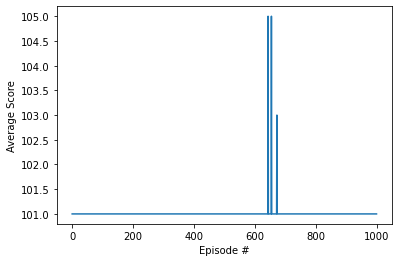

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainer.scores)), trainer.scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.3 Agent (Replay Memory) - Losses

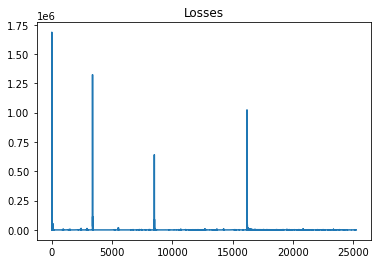

In [8]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

### 4.2 Agent (Prioritized Memory) - Training

In [10]:
%%time

params.prioritized_memory = True

agent = Agent(**params.dict())
agent.prep_state = custom_prep_state

trainer = Trainer(agent, env, n_episodes=1000, early_stop=200, verbose=True)
trainer.run()

print(f"Episode: {trainer.last_episode} - Score: {trainer.best_score}")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Episode 10	Average Score: 101.00
Episode 20	Average Score: 101.00
Episode 30	Average Score: 101.00
Episode 40	Average Score: 101.00
Episode 50	Average Score: 101.00
Episode 60	Average Score: 101.00
Episode 70	Average Score: 101.00
Episode 80	Average Score: 101.00
Episode 90	Average Score: 101.00
Episode 100	Average Score: 101.00
Episode 110	Average Score: 101.00
Episode 120	Average Score: 101.00
Episode 130	Average Score: 101.00
Episode 140	Average Score: 101.00
Episode 142	Average Score: 101.00

### 4.2 Agent (Prioritized Memory) - Scores

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(trainer.scores)), trainer.scores)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()

### 4.2 Agent (Prioritized Memory) - Losses

In [ ]:
plt.plot(agent.losses)
plt.title("Losses")
plt.show()

## 5. Save network weights

In [30]:
agent.save_model(params.model_dir)

'../models/DuelingDQN-FlappyBird.pt'

## 6. Load network weights

In [ ]:
agent.load_model(params.model_dir)

## 7. Test the agent

In [17]:
env = flappy_bird_gym.make("FlappyBird-rgb-v0")

play_env(agent, env, render=True)

Score: 101


## 8. Conclusions

Pending